In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
from functions import compute_ivt,to_nc
from matplotlib import rc,animation
from matplotlib.animation import FuncAnimation
from IPython import display

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [3]:
cat = col.search(source_id=['NorESM2-LM'], experiment_id=['historical'], table_id=['day'], variable_id=['hus','va'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-LM,historical,r1i1p1f1,day,hus,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...,NaN,20190815
1,CMIP,NCC,NorESM2-LM,historical,r1i1p1f1,day,va,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...,NaN,20190815


In [5]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [6]:
dataset_list = list(dset_dict.keys())
dataset_list

['CMIP.NCC.NorESM2-LM.historical.day.gn']

In [8]:
dset = dset_dict[dataset_list[0]]
dset = dset.sel(member_id='r1i1p1f1',time=slice("2000-01-01", "2014-12-31"))
dset

<xarray.Dataset>
Dimensions:    (lat: 96, lon: 144, plev: 8, time: 5475, bnds: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
  * time       (time) object 2000-01-01 12:00:00 ... 2014-12-31 12:00:00
    member_id  <U8 'r1i1p1f1'
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(5475, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    hus        (time, plev, lat, lon) float32 dask.array<chunksize=(30, 8, 96, 144), meta=np.ndarray>
    va         (time, plev, lat, lon) float32 dask.array<chunksize=(54, 8, 96, 144), meta=np.ndarray>
Attributes: (12/50)
    parent_experiment_id:      piControl
    branch_time_in_child:      0.0
    institution:               NorESM Climate modeling Consortium consisting ...
    parent_mip_era:            CMIP6
    activity_id:               CMIP
    intake_esm_varname:        hus\nva
    ...                        ...
    sub_experiment:            none
    experiment:                all-forcing simulation of the recent past
    grid_label:                gn
    contact:                   Please send any requests or bug reports to nor...
    parent_variant_label:      r1i1p1f1
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-LM.historical.day.gn

In [9]:
vas = dset.va
hus = dset.hus
plev = dset.plev
lat_ = hus.lat
lon_ = hus.lon

In [10]:
ivt = compute_ivt(hus,vas,plev)

In [11]:
ivt_ns = ivt.copy()
ivt_ns = xr.where(ivt_ns.lat<0,-ivt_ns,ivt_ns,True) # minus for southern hemisphere (positive toward the pole)
ivt_ns_pos = xr.where(ivt_ns<0,ivt_ns*0,ivt_ns,True) # negative values = not poleward
ivt_ns_pos


<xarray.DataArray 'lat' (lat: 96, time: 5475, lon: 144)>
dask.array<where, shape=(96, 5475, 144), dtype=float64, chunksize=(96, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    member_id  <U8 'r1i1p1f1'
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) object 2000-01-01 12:00:00 ... 2014-12-31 12:00:00

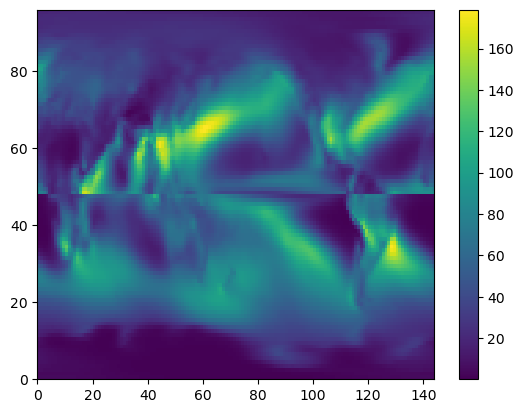

In [36]:
plt.pcolormesh(ivt_ns_pos.mean(dim='time'))
plt.colorbar()
plt.show()

In [12]:
q98 = ivt_ns_pos.chunk(dict(time=-1)).quantile(0.98,'time')
print(q98)
print(ivt_ns_pos.shape)
#quantile(0.98,dim='time',keep_attrs=True)

<xarray.DataArray 'lat' (lat: 96, lon: 144)>
dask.array<getitem, shape=(96, 144), dtype=float64, chunksize=(96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    quantile  float64 0.98
(96, 5475, 144)


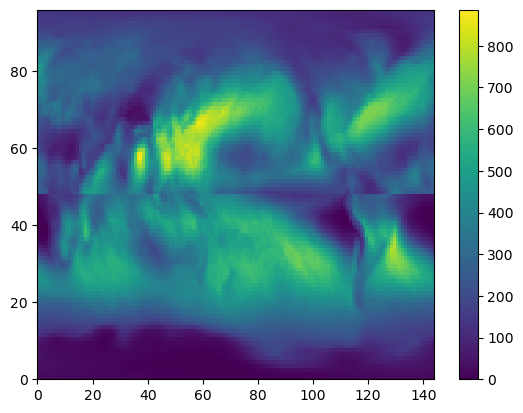

In [43]:
plt.pcolormesh(q98)
plt.colorbar()
plt.show()

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


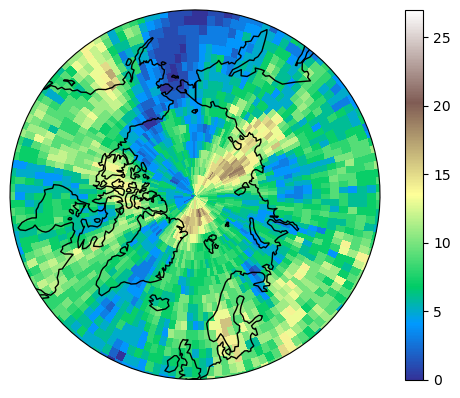

In [13]:
excess14 = ivt_ns_pos.sel(time=slice("2014-01-01", "2014-12-31"))
excess14 = excess14-q98
excess14 = xr.where(excess14>0,1,excess14*0)


pole='Arctic'

if pole=='Antarctic':
    ax1 = plt.subplot(1,1,1,projection=ccrs.SouthPolarStereo())
    ax1.set_extent([-180,180,-50,-90], ccrs.PlateCarree())
else:
    ax1 = plt.subplot(1,1,1,projection=ccrs.NorthPolarStereo())
    ax1.set_extent([-180,180,50,90], ccrs.PlateCarree())

ax1.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(0.5,0.5,0.5,0))

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
m = ax1.pcolormesh(lon_,lat_,excess14.sum(dim='time'),transform=ccrs.PlateCarree(),cmap='terrain')

#plt.pcolormesh(excess.sum(dim='time'))
plt.colorbar(m)
plt.show()

(365, 144)
(96,)


TypeError: Dimensions of C (365, 144) are incompatible with X (145) and/or Y (96); see help(pcolormesh)

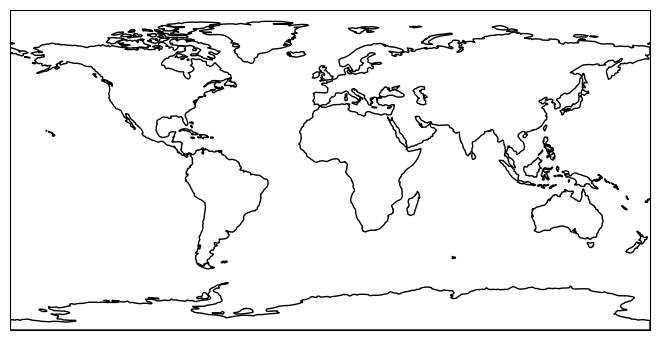

In [14]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
vertical_array = excess14
print(vertical_array[0,:,:].shape)
print(lat_.shape)
    
ax1 = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
#ax1.set_extent([-180,180,50,90], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(0.5,0.5,0.5,0))
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax1.set_boundary(circle, transform=ax1.transAxes)
cax1 = ax1.pcolormesh(lon_,lat_,vertical_array[0,:,:],transform=ccrs.PlateCarree(),cmap='Blues',vmin=0,vmax=1)
cbar = plt.colorbar(cax1)
ax1.set_title(vertical_array[0,:,:].time.values.astype('datetime64[D]'))

def animate(i):
   cax1.set_array(vertical_array[i,:,:].values.flatten())
   ax1.set_title(vertical_array[i,:,:].time.values.astype('datetime64[D]'))
 
anim = animation.FuncAnimation(fig, animate, interval=200, frames=40)
video = anim.to_jshtml()
html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
res_lon = lon_.values[1]-lon_.values[0]
res_lat = lat_.values[1]-lat_.values[0]
origin_lat = lat_.values[0]
origin_lon = lon_.values[0]

lat_stepsize = res_lat
lon_stepsize = res_lon

lat_index_list = []
lon_index_list = []
landfall_idx = []

for t in range(excess14.shape[0]):
    ar_loc = excess14[t,:,:]
    indices = np.where(ar_loc > 0)
    y_idx = lat_[indices[0]]
    x_idx = lon_[indices[1]]
    y_splitted_temp = np.split(y_idx, np.where(np.diff(y_idx) < res_lat)[0] +1)
    x_splitted_temp = np.split(x_idx, np.where(np.diff(y_idx) < res_lat)[0] +1)
    y_longest = max(y_splitted_temp, key=len)
    x_longest = max(x_splitted_temp, key=len)
    x_reverse = []
    y_reverse = []		
    try:
        if y_longest.max() - y_longest.min() > 20 :
            reverse_grid = np.arange(min(x_longest),max(x_longest)+0.5,res_lon)
            for i in reverse_grid:
                x_index_reverse = np.where(x_longest == i)
                x_reverse = np.concatenate((x_reverse,x_longest[x_index_reverse]))
                y_reverse = np.concatenate((y_reverse,y_longest[x_index_reverse]))
    except ValueError:
        pass
    x_splitted = np.split(x_reverse, np.where(np.diff(x_reverse) > 20)[0] +1)
    y_splitted = np.split(y_reverse, np.where(np.diff(x_reverse) > 20)[0] +1)
    try:
        if x_splitted[0][0]+360 - x_splitted[-1][-1] < 20:
            x_splitted[-1] = np.concatenate((x_splitted[-1],x_splitted[0]))
            x_splitted = np.delete(x_splitted,0,0)
            y_splitted[-1] = np.concatenate((y_splitted[-1],y_splitted[0]))
            y_splitted = np.delete(y_splitted,0,0)
    except IndexError:
        pass		
    x_shape = []
    y_shape = []
    x_shape_landfall = []
    y_shape_landfall = []
    for i in range(0,len(y_splitted)):
        x_reverse2 = []
        y_reverse2 = []
        x_final = []
        y_final = []
        try:	
            reverse_grid2 = np.arange(max(y_splitted[i]),min(y_splitted[i])-0.5,res_lat)
            for j in reverse_grid2:
                y_index_reverse2 = np.where(y_splitted[i] == j)
                x_reverse2 = np.concatenate((x_reverse2,x_splitted[i][y_index_reverse2]))
                y_reverse2 = np.concatenate((y_reverse2,y_splitted[i][y_index_reverse2]))
        except ValueError:
            pass
        try:
            y_splitted_final = np.split(y_reverse2, np.where(np.diff(y_reverse2) < res_lat)[0] +1)
            x_splitted_final = np.split(x_reverse2, np.where(np.diff(y_reverse2) < res_lat)[0] +1)
            for z in range(0,len(y_splitted_final)):
                if y_splitted_final[z].max() - y_splitted_final[z].min() > 20:
                    y_final = np.concatenate((y_final, y_splitted_final[z]))
                    x_final = np.concatenate((x_final, x_splitted_final[z]))
            x_shape = np.concatenate((x_shape,x_final))
            y_shape = np.concatenate((y_shape,y_final))				
        except ValueError:
            pass
    lat_index = (y_shape - origin_lat) / lat_stepsize 
    lon_index = (x_shape - origin_lon) / lon_stepsize 
    lat_index = lat_index.astype(int)
    lon_index = lon_index.astype(int)
    if(len(lat_index) > 0):
        lat_index_list.append(lat_index.data)
    else:
        lat_index_list.append(lat_index)    
    if(len(lon_index) > 0):
        lon_index_list.append(lon_index.data)
    else:
        lon_index_list.append(lon_index)

In [45]:
print(lat_index_list)

[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype

TypeError: Dimensions of C (365, 144) are incompatible with X (145) and/or Y (96); see help(pcolormesh)

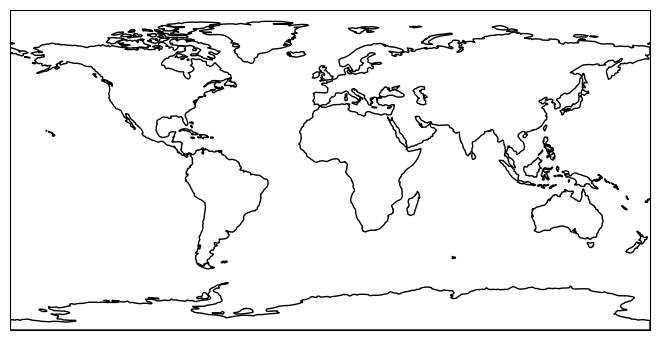

In [15]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
vertical_array = excess14
    
ax1 = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(0.5,0.5,0.5,0))
cax1 = ax1.pcolormesh(lon_,lat_,vertical_array[0,:,:],transform=ccrs.PlateCarree(),cmap='Blues',vmin=0,vmax=1)
cbar = plt.colorbar(cax1)
ax1.set_title(vertical_array[0,:,:].time.values.astype('datetime64[D]'))

def animate(i):
   cax1.set_array(vertical_array[i,:,:].values.flatten())
   ax1.set_title(vertical_array[i,:,:].time.values.astype('datetime64[D]'))
 
anim = animation.FuncAnimation(fig, animate, interval=200, frames=365)
video = anim.to_jshtml()
html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
vertical_array = ivt.sel(time=slice("2014-01-01", "2014-12-31"))

ax1 = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(0.5,0.5,0.5,0))
cax1 = ax1.pcolormesh(lon_,lat_,vertical_array[0,:,:],transform=ccrs.PlateCarree(),cmap='cividis',vmin=0,vmax=0.01)
cbar = plt.colorbar(cax1)
ax1.set_title(vertical_array[0,:,:].time.values.astype('datetime64[D]'))

def animate(i):
   cax1.set_array(vertical_array[i,:,:].values.flatten())
   ax1.set_title(vertical_array[i,:,:].time.values.astype('datetime64[D]'))
 
anim = animation.FuncAnimation(fig, animate, interval=200, frames=100)
video = anim.to_jshtml()
html = display.HTML(video)
display.display(html)
plt.close()
